In [29]:
import os
import time
import ollama
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

FRENCH = True

In [30]:
def messages_from_prompt(prompt):
    messages = []
    with open(f"prompts/{prompt}", "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    for line in lines:
        role = line.split(" ")[0]
        content = line[len(role)+1:]
        messages.append({"role": role, "content": content})
    return messages

In [31]:
# for all prompts evaluate the model

# all the text files in the prompts directory
prompts = [f for f in os.listdir("prompts") if f.endswith(".txt")]
models = ["openchat", "mistral", "llama2", "gemma", "openhermes"]

for _ in range(500):

    time_str = time.strftime("%Y-%m-%d_%H-%M-%S")
    time_df = pd.DataFrame(columns=["model", "prompt", "time_per_char", "time_init", "time_total"])

    for model in models:
        print(f"Model: {model}")
        ollama.chat(
            model=model,
            messages=[],
            stream=False
        )
        for prompt in prompts:
            print(f"Prompt: {prompt}")
            messages = messages_from_prompt(prompt)
            response = ""
            first_chunk = True
            start = time.time()
            stream = ollama.chat(
                model=model,
                messages=messages,
                stream=True
            )
            for chunk in stream:
                if first_chunk:
                    before_stream = time.time()
                    first_chunk = False
                response += chunk['message']['content']
                print(response, end="\r")
            end = time.time()
            time_df = pd.concat([time_df, pd.DataFrame([{
                "model": model,
                "prompt": prompt,
                "time_per_char": (end - before_stream) / len(response),
                "time_init": before_stream - start,
                "time_total": end - start
            }])])
            print(f"Time: {end - start}")
            with open(f"responses/{model}_chat_{time_str}_{prompt}", "w", encoding="utf-8") as f:
                f.write(response)
            time.sleep(1)

    # write the time df to a file
    with open(f"time_df_{time_str}.csv", "w") as f:
        time_df.to_csv(f, index=False)

## Analysis

### Time

In [32]:
# read csv file

# read all the csv files in the current directory beginning with time_df
time_files = [f for f in os.listdir() if f.startswith("time_df")]

time_dfs = []
for time_file in time_files:
    time_dfs.append(pd.read_csv(time_file))

time_df = pd.concat(time_dfs)

# time_df is the mean of each couple model-prompt
time_df = time_df.groupby(["model", "prompt"]).mean().reset_index()


print(time_df.head())
print("len(time_df):", len(time_df))
print(time_df["model"].unique(), f"(len: {len(time_df['model'].unique())})")
print(time_df["prompt"].unique(), f"(len: {len(time_df['prompt'].unique())})")
print("number of df:", len(time_dfs))

   model        prompt  time_per_char  time_init  time_total
0  gemma  prompt_1.txt       0.004399   0.696099    2.134491
1  gemma  prompt_2.txt       0.004847   0.138729    0.930023
2  gemma  prompt_3.txt       0.005218   0.110270    0.788714
3  gemma  prompt_4.txt       0.004531   0.355678    1.461625
4  gemma  prompt_5.txt       0.005151   0.132208    0.980910
len(time_df): 45
['gemma' 'llama2' 'mistral' 'openchat' 'openhermes'] (len: 5)
['prompt_1.txt' 'prompt_2.txt' 'prompt_3.txt' 'prompt_4.txt'
 'prompt_5.txt' 'prompt_6.txt' 'prompt_7.txt' 'prompt_8.txt'
 'prompt_9.txt'] (len: 9)
number of df: 31


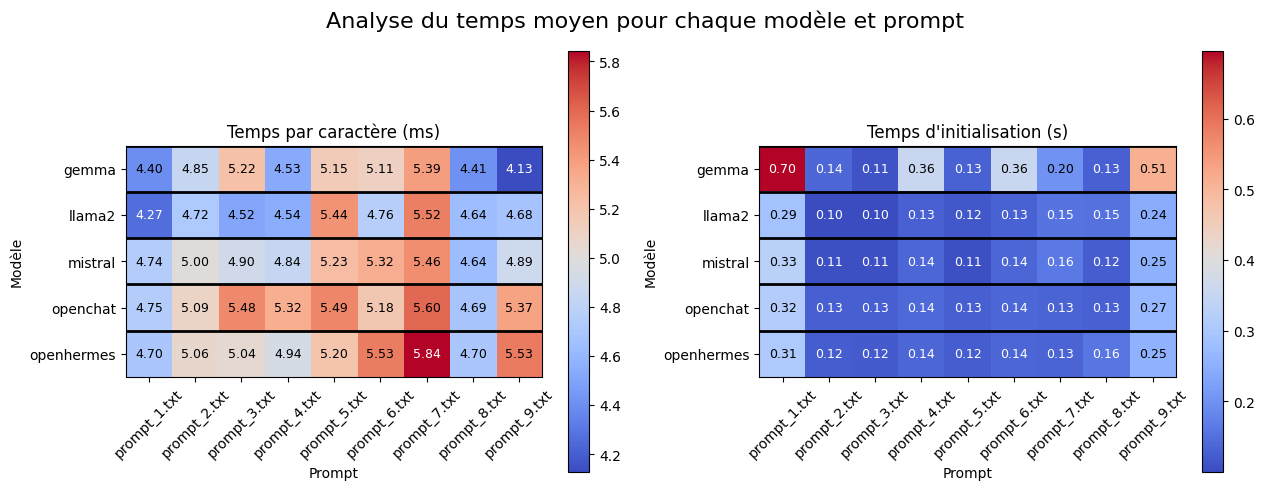

C:\Users\echriston\AppData\Local\Temp\ipykernel_13700\2409846794.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(models, rotation=45)
C:\Users\echriston\AppData\Local\Temp\ipykernel_13700\2409846794.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(models, rotation=45)


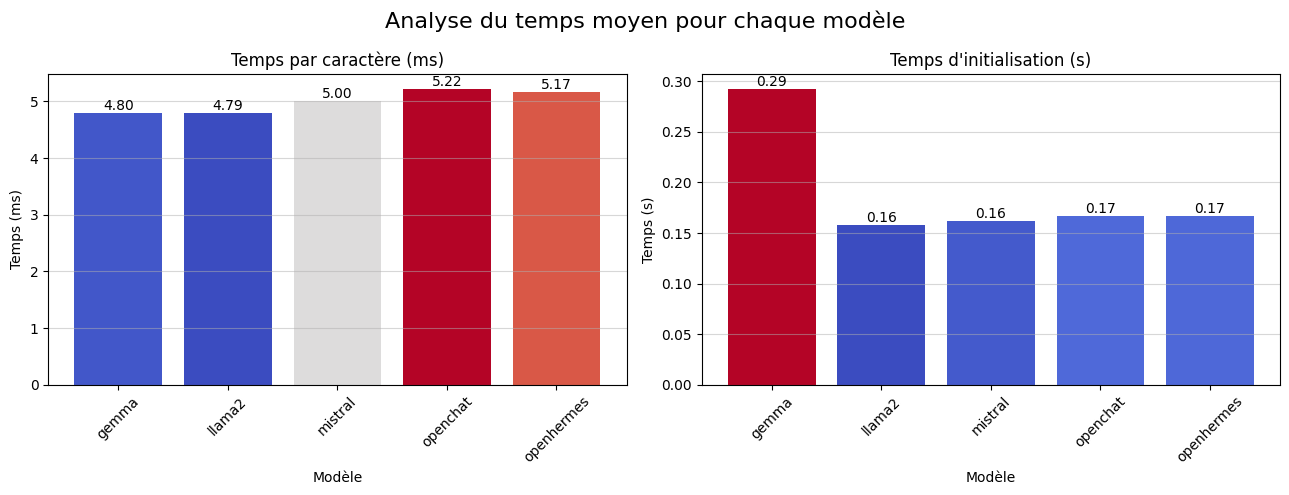

In [35]:
# plot the time per character distribution for each model

prompts = time_df["prompt"].unique().tolist()
models = time_df["model"].unique().tolist()

# build a matrix of EVERY_FEATURE for each model for each prompt
time_per_char_ms_matrix = []
time_init_matrix = []
for model in models:
    time_per_char_ms = []
    time_init = []
    for prompt in prompts:
        # time per char in ms (x1000 to get ms)
        sub_df = time_df[(time_df["model"] == model) & (time_df["prompt"] == prompt)]
        if len(sub_df) == 0:
            prompts.remove(prompt)
        else:
            time_per_char_ms.append(sub_df["time_per_char"].values[0] * 1000)
            time_init.append(sub_df["time_init"].values[0])
    time_per_char_ms_matrix.append(time_per_char_ms)
    time_init_matrix.append(time_init)


COLOR_MAP_NAME = "coolwarm"

def add_values_to_each_cell(matrix, ax):
    cmap = plt.colormaps.get_cmap(COLOR_MAP_NAME)
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    for i in range(len(models)):
        for j in range(len(prompts)):
            color = cmap((matrix[i][j] - min_val) / (max_val - min_val))
            luminance = 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
            if luminance > 0.5:
                text_color = "black"
            else:
                text_color = "white"
            ax.text(j, i, f"{matrix[i][j]:.2f}", ha="center", va="center", color=text_color, fontsize=9)


# plot the matrices like heatmaps
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].imshow(time_per_char_ms_matrix, cmap=COLOR_MAP_NAME)
ax[0].set_xticks(range(len(prompts)))
ax[0].set_yticks(range(len(models)))
ax[0].set_xticklabels(prompts, rotation=45)
ax[0].set_yticklabels(models)
if FRENCH:
    ax[0].set_title("Temps par caractère (ms)")
    ax[0].set_xlabel("Prompt")
    ax[0].set_ylabel("Modèle")
else:
    ax[0].set_title("Time per character (ms)")
    ax[0].set_xlabel("Prompt")
    ax[0].set_ylabel("Model")
add_values_to_each_cell(time_per_char_ms_matrix, ax[0])

ax[1].imshow(time_init_matrix, cmap=COLOR_MAP_NAME)
ax[1].set_xticks(range(len(prompts)))
ax[1].set_yticks(range(len(models)))
ax[1].set_xticklabels(prompts, rotation=45)
ax[1].set_yticklabels(models)
if FRENCH:
    ax[1].set_title("Temps d'initialisation (s)")
    ax[1].set_xlabel("Prompt")
    ax[1].set_ylabel("Modèle")
else:
    ax[1].set_title("Initialization time (s)")
    ax[1].set_xlabel("Prompt")
    ax[1].set_ylabel("Model")
add_values_to_each_cell(time_init_matrix, ax[1])


# grid lines (horizontal)
for i in range(len(models)):
    ax[0].axhline(i-0.5, color="black", lw=2)
    ax[1].axhline(i-0.5, color="black", lw=2)

if FRENCH:
    fig.suptitle("Analyse du temps moyen pour chaque modèle et prompt", fontsize=16)
else:
    fig.suptitle("Mean time analysis for each model and prompt", fontsize=16)
plt.colorbar(ax[0].imshow(time_per_char_ms_matrix, cmap=COLOR_MAP_NAME), ax=ax[0])
plt.colorbar(ax[1].imshow(time_init_matrix, cmap=COLOR_MAP_NAME), ax=ax[1])
plt.tight_layout()
# save the figure
plt.savefig("time_analysis_matrices.png")
plt.show()


# plot the mean over the prompts for each model
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
time_per_char_ms_mean = np.mean(time_per_char_ms_matrix, axis=1)
time_init_mean = np.mean(time_init_matrix, axis=1)
cmap = plt.colormaps.get_cmap(COLOR_MAP_NAME)


ax[0].bar(models, time_per_char_ms_mean, color=cmap((time_per_char_ms_mean - np.min(time_per_char_ms_mean)) / (np.max(time_per_char_ms_mean) - np.min(time_per_char_ms_mean))))
for i, v in enumerate(time_per_char_ms_mean):
    ax[0].text(i, v, f"{v:.2f}", ha="center", va="bottom")

if FRENCH:
    ax[0].set_title("Temps par caractère (ms)")
    ax[0].set_ylabel("Temps (ms)")
    ax[0].set_xlabel("Modèle")
else:
    ax[0].set_title("Time per character (ms)")
    ax[0].set_ylabel("Time (ms)")
    ax[0].set_xlabel("Model")
ax[0].set_xticklabels(models, rotation=45)
ax[0].grid(axis="y", alpha=0.5)

ax[1].bar(models, time_init_mean, color=cmap((time_init_mean - np.min(time_init_mean)) / (np.max(time_init_mean) - np.min(time_init_mean))))
for i, v in enumerate(time_init_mean):
    ax[1].text(i, v, f"{v:.2f}", ha="center", va="bottom")

if FRENCH:
    ax[1].set_title("Temps d'initialisation (s)")
    ax[1].set_ylabel("Temps (s)")
    ax[1].set_xlabel("Modèle")
else:
    ax[1].set_title("Initialization time (s)")
    ax[1].set_ylabel("Time (s)")
    ax[1].set_xlabel("Model")
ax[1].set_xticklabels(models, rotation=45)
ax[1].grid(axis="y", alpha=0.5)

if FRENCH:
    fig.suptitle("Analyse du temps moyen pour chaque modèle", fontsize=16)
else:
    fig.suptitle("Mean time analysis for each model", fontsize=16)
plt.tight_layout()
# save the figure
plt.savefig("time_analysis_mean.png")
plt.show()


### French

In [19]:
import langdetect
import numpy as np

In [20]:
# for each response, find the language of each sentence

responses = [f for f in os.listdir("responses") if f.endswith(".txt")]
lang_df = pd.DataFrame(columns=["model", "sentence", "lang", "file"])

for response in responses:
    with open(f"responses/{response}", "r", encoding="utf-8") as f:
        text = f.read()
    
    model = response.split("_")[0]

    sentences = text.split(".")
    for sentence in sentences:
        if len(sentence.split(" ")) < 4:
            continue
        try:
            lang = langdetect.detect(sentence)
        except:
            continue
        
        lang_df = pd.concat([lang_df, pd.DataFrame([{ "model": model, "sentence": sentence, "lang": lang, "file": response }])])

In [21]:
print(lang_df.head())

   model                                           sentence lang  \
0  gemma  Je suis un robot assistant et je suis là pour ...   fr   
0  gemma   Je suis informé sur les services que propose ...   fr   
0  gemma   L'entreprise intervient dans les secteurs Ind...   fr   
0  gemma  Je suis désolé, mais je n'ai pas la capacité d...   fr   
0  gemma   Je suis un robot assistant spécialisé en aide...   fr   

                                          file  
0  gemma_chat_2024-04-02_17-09-44_prompt_1.txt  
0  gemma_chat_2024-04-02_17-09-44_prompt_1.txt  
0  gemma_chat_2024-04-02_17-09-44_prompt_1.txt  
0  gemma_chat_2024-04-02_17-09-44_prompt_2.txt  
0  gemma_chat_2024-04-02_17-09-44_prompt_2.txt  


In [22]:
# get models from lang_df
models = lang_df["model"].unique()

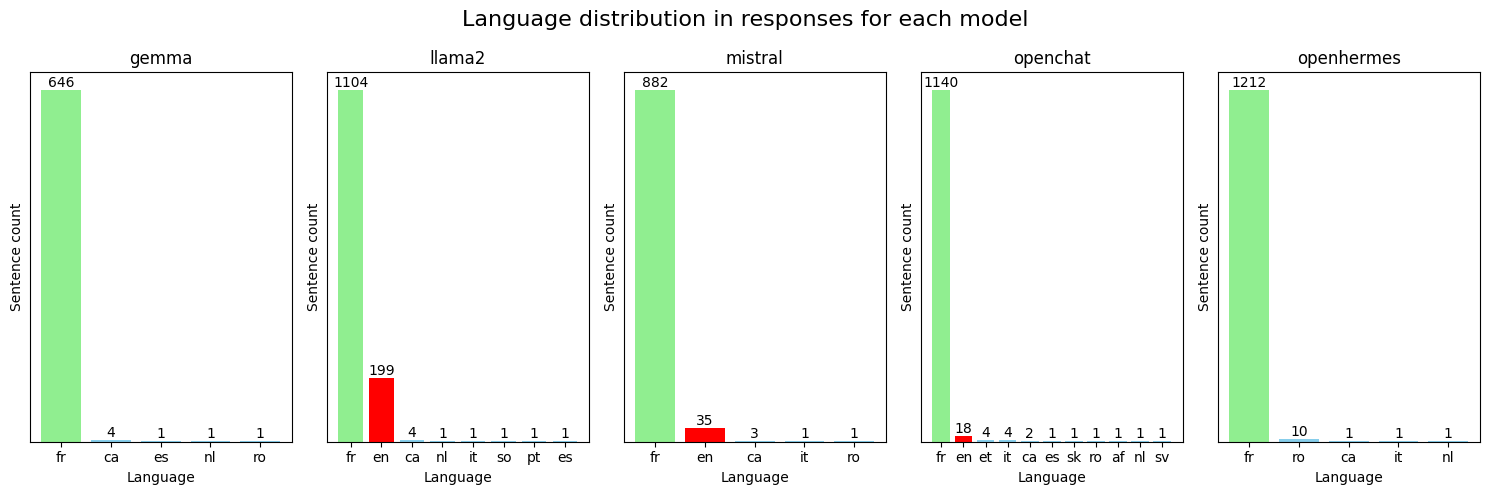

In [23]:
# plot the languages for each model
fig, ax = plt.subplots(1, len(models), figsize=(15, 5))
color_dict = {"fr": "lightgreen", "en": "red", "unknown": "lightgrey"}
for i, model in enumerate(models):
    sub_df_1 = lang_df[lang_df["model"] == model]
    # color sky blue or light green if french
    ax[i].bar(sub_df_1["lang"].value_counts().index, sub_df_1["lang"].value_counts().values, color=[color_dict[lang] if lang in color_dict else "skyblue" for lang in sub_df_1["lang"].value_counts().index])
    # add text count on top of each bar
    for j, count in enumerate(sub_df_1["lang"].value_counts().values):
        ax[i].text(j, count, str(count), ha="center", va="bottom")
    ax[i].set_title(model)
    ax[i].set_xlabel("Language")
    ax[i].set_ylabel("Sentence count")
    # no y ticks
    ax[i].set_yticks([])

# big title
fig.suptitle("Language distribution in responses for each model", fontsize=16)

plt.tight_layout()
plt.show()


In [24]:
# print some non french sentences (and non unknown)

for model in models:
    print(f"Model: {model}")
    sub_df_1 = lang_df[(lang_df["model"] == model) & (lang_df["lang"] != "fr") & (lang_df["lang"] != "unknown")]
    print(sub_df_1)
    print("\n\n")

Model: gemma
   model                      sentence lang  \
0  gemma   J'ai dormi très bien, merci   ca   
0  gemma        J'ai dormi bien, merci   es   
0  gemma   J'ai dormi très bien, merci   ca   
0  gemma        Avez-vous bien dormi ?   nl   
0  gemma   J'ai dormi très bien, merci   ca   
0  gemma            Merci de me parler   ca   
0  gemma        J'ai bien dormi, merci   ro   

                                          file  
0  gemma_chat_2024-04-03_12-23-20_prompt_7.txt  
0  gemma_chat_2024-04-03_12-46-00_prompt_7.txt  
0  gemma_chat_2024-04-03_12-56-56_prompt_7.txt  
0  gemma_chat_2024-04-03_13-07-09_prompt_7.txt  
0  gemma_chat_2024-04-03_13-14-27_prompt_7.txt  
0  gemma_chat_2024-04-08_15-12-40_prompt_7.txt  
0                      gemma_chat_prompt_7.txt  



Model: llama2
     model                                           sentence lang  \
0   llama2  Pleasure to assist you! Pacte Novation is a gr...   en   
0   llama2   They operate in various sectors such as indus...

## Human eval

Let's evaluate the models by comparing their outputs two by two, same as in arenas.

The program will take a random prompt and two random responses from different models, and ask the user to choose the best one.

The program will then calculate the win rate of each model.

In [25]:
def get_random_prompt():
    prompts = [f for f in os.listdir("prompts") if f.endswith(".txt")]
    return np.random.choice(prompts)

def get_two_random_responses_different_models(prompt_file):
    responses = [f for f in os.listdir("responses") if f.endswith(".txt")]
    responses = [f for f in responses if f.split("_")[-1] == prompt_file.split("_")[-1]]
    response1 = np.random.choice(responses)
    response2 = np.random.choice([f for f in responses if f.split("_")[0] != response1.split("_")[0]])
    return response1, response2

In [26]:
# each time, get a random prompt and two random responses from different models
prompt = get_random_prompt()
response1, response2 = get_two_random_responses_different_models(prompt)

# print the prompt and the two responses
print(f"Prompt: {prompt}")
with open(f"prompts/{prompt}", "r", encoding="utf-8") as f:
    print(f.read())

print(f"\nResponse 1:")
with open(f"responses/{response1}", "r", encoding="utf-8") as f:
    print(f.read())

print(f"\nResponse 2:")
with open(f"responses/{response2}", "r", encoding="utf-8") as f:
    print(f.read())

# ask the user to write 1 or 2 to choose the best response
time.sleep(1)
response = input("Which response is the best? (1 or 2) (0 for both bad and 3 for both good): ")

model1 = response1.split("_")[0]
model2 = response2.split("_")[0]

# store the match in a csv file
with open("matches.csv", "a") as f:
    f.write(f"{prompt},{model1},{model2},{response}\n")

Prompt: prompt_8.txt
user Pourquoi la vie ? (fais pas une réponse trop longue stp)

Response 1:
 La vie est un mystère et un sujet passionnant qui a suscité des débats et des réflexions au fil des siècles. Bien que je ne peux pas répondre à cette question en utilisant une phrase courte, je vais essayer de fournir une réponse concise : La vie est un processus complexe qui a émergé de l'évolution et de la sélection naturelle pour répondre aux besoins du milieu environnant. Elle est entourée de mystères en raison de notre capacité à ressentir des émotions, à penser et à créer. En fin de compte, cela rend la vie intéressante et inestimable.

Response 2:
La vie est un enigma. Nous n'avons pas la réponse à ce mystère, mais nous pouvons essayer d'en comprendre les aspects. La vie est un cadeau précieux, même si elle est parfois difficile. Nous devons apprécier les petites choses, les moments heureux et les relations précieux. Nous devons également reconnaître la beauté et la puissance de la v

In [27]:
# read the matches file
matches = pd.read_csv("matches.csv", header=0)
print(matches.head())
# prompt,model1,model2,response
# response is 1, 2, 3 or 0

    prompt_file      model1    model2  result
0  prompt_3.txt     mistral    llama2       1
1  prompt_6.txt      llama2  openchat       2
2  prompt_7.txt       gemma   mistral       1
3  prompt_6.txt       gemma    llama2       1
4  prompt_5.txt  openhermes  openchat       2


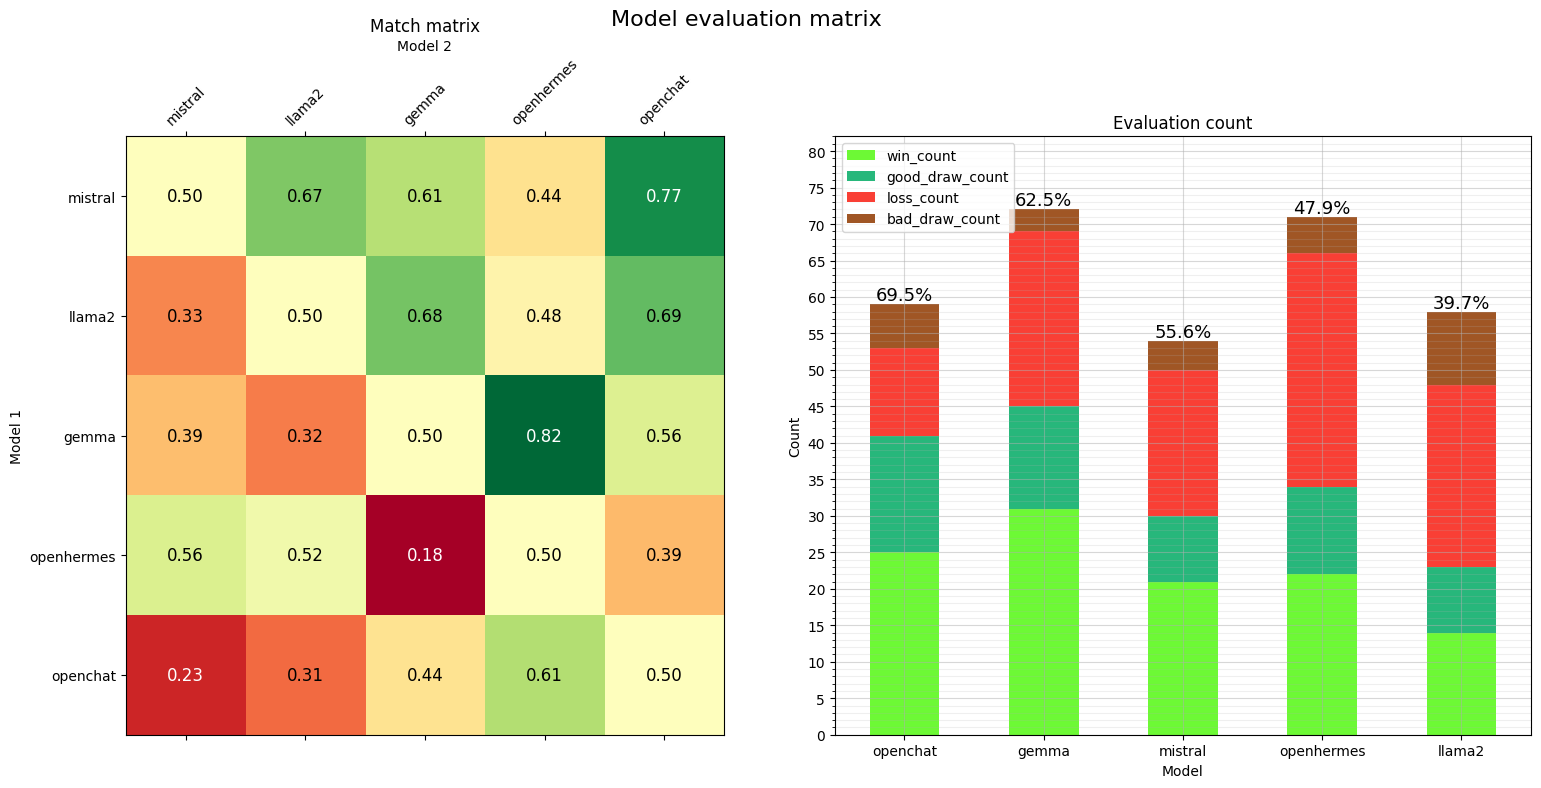

In [28]:
# build the matrix of matches
models = matches["model1"].unique()
# fille the matrix with 0.5
match_matrix = np.zeros((len(models), len(models))) + 0.5

for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        # get all the matches between model1 and model2
        sub_df_1 = matches[(matches["model1"] == model1) & (matches["model2"] == model2)]
        sub_df_2 = matches[(matches["model1"] == model2) & (matches["model2"] == model1)]

        if len(sub_df_1) + len(sub_df_2) == 0:
            continue

        # win rate of model1
        victories = len(sub_df_1[sub_df_1["result"] == 1]) \
                  + len(sub_df_2[sub_df_2["result"] == 2]) \
                  + 0.5 * (
                        len(sub_df_1[sub_df_1["result"] == 3]) \
                      + len(sub_df_2[sub_df_2["result"] == 3]) \
                      + len(sub_df_1[sub_df_1["result"] == 0]) \
                      + len(sub_df_2[sub_df_2["result"] == 0])) 
            
        win_rate = victories / (len(sub_df_1) + len(sub_df_2))

        match_matrix[i, j] = win_rate


# sort the models by total win rate
total_win_rate = np.sum(match_matrix, axis=1)
sorted_indices = np.argsort(total_win_rate)[::-1]
sorted_models = models[sorted_indices]

# rebuild the matrix with the sorted models
new_match_matrix = np.zeros((len(models), len(models)))
for i, model1 in enumerate(sorted_models):
    for j, model2 in enumerate(sorted_models):
        new_match_matrix[i, j] = match_matrix[sorted_indices[i], sorted_indices[j]]


COLOR_MAP_NAME = "RdYlGn"

def add_values_to_each_cell(matrix, ax):
    cmap = plt.colormaps.get_cmap(COLOR_MAP_NAME)
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            color = cmap((matrix[i][j] - min_val) / (max_val - min_val))
            luminance = 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
            if luminance > 0.5:
                text_color = "black"
            else:
                text_color = "white"
            ax.text(j, i, f"{matrix[i][j]:.2f}", ha="center", va="center", color=text_color, fontsize=12)


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot the matrix
cax = ax[0].matshow(new_match_matrix, cmap=COLOR_MAP_NAME)
ax[0].set_xticks(range(len(models)))
ax[0].set_yticks(range(len(models)))
ax[0].set_xticklabels(models, rotation=45)
ax[0].set_yticklabels(models)
ax[0].set_title("Match matrix")
# x label up top
ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel("Model 2")
ax[0].set_ylabel("Model 1")
add_values_to_each_cell(new_match_matrix, ax[0])

# plot the evaluation count, stacked column chart

# count the number of evaluations for each model
data_count = {}
for i, model1 in enumerate(models):
    eval_count = len(matches[(matches["model1"] == model1) | (matches["model2"] == model1)])
    win_count = len(matches[(matches["model1"] == model1) & (matches["result"] == 1)]) + len(matches[(matches["model2"] == model1) & (matches["result"] == 2)])
    loss_count = len(matches[(matches["model1"] == model1) & (matches["result"] == 2)]) + len(matches[(matches["model2"] == model1) & (matches["result"] == 1)])
    bad_draw_count = len(matches[(matches["model1"] == model1) & (matches["result"] == 0)]) + len(matches[(matches["model2"] == model1) & (matches["result"] == 0)])
    good_draw_count = len(matches[(matches["model1"] == model1) & (matches["result"] == 3)]) + len(matches[(matches["model2"] == model1) & (matches["result"] == 3)])
    data_count[model1] = {
        "eval_count" : eval_count,
        "win_count" : win_count,
        "loss_count" : loss_count,
        "bad_draw_count" : bad_draw_count,
        "good_draw_count" : good_draw_count,
    }

# build the stacked column chart
data = pd.DataFrame(data_count).T
data = data.loc[sorted_models]
data[["win_count", "good_draw_count", "loss_count", "bad_draw_count"]].plot(kind="bar", stacked=True, ax=ax[1], color=["#6DF935", "#27B77B", "#F93F35", "#A05625"], rot=0)
ax[1].set_title("Evaluation count")
ax[1].set_xlabel("Model")
ax[1].set_ylabel("Count")
ax[1].legend(["win_count", "good_draw_count", "loss_count", "bad_draw_count"], loc="upper left")
# grid lines (horizontal)
major_ticks = np.arange(0, 201, 5)
minor_ticks = np.arange(0, 201, 1)
ax[1].set_yticks(major_ticks)
ax[1].set_yticks(minor_ticks, minor=True)
ax[1].grid(which='major', alpha=0.5)
ax[1].grid(which='minor', alpha=0.2)
ax[1].set_ylim([0, np.max(data["eval_count"]) + 10])
# add text of % good
for i, model in enumerate(sorted_models):
    total = data["eval_count"][model]
    good = data["win_count"][model] + data["good_draw_count"][model]
    ax[1].text(i, total, f"{good / total * 100:.1f}%", ha="center", va="bottom", fontsize=13)
fig.suptitle("Model evaluation matrix", fontsize=16)
plt.tight_layout()
plt.show()

# 2.54, 2.23, 2.18, 1.55, 1.5
        